Use PyTorch, GPU and Colab.

Implement a simple convolutional neural network with training and validation on CIFAR10 dataset, limited to subset of 3k train and 3k test images.
Train the neural network for ~30 epochs with Adam optimizer and batch size equal to 64. Implement validation on batches.
  
Code the following incrementally:
- Prevent overfitting using a) dropout and b) data augmentation.
- Add test augmentation.
- For better results use transfer learning.

In [1]:
import torch
torch.manual_seed(0)
 
import random
random.seed(0)
 
import numpy as np
np.random.seed(0)
 
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.utils.data as data_utils

In [2]:
transform = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) ] )

batch_size = 64

indices = torch.arange(3000)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainset = data_utils.Subset(trainset, indices)

testset = data_utils.Subset(testset, indices)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


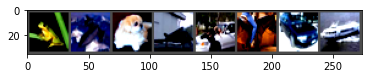

frog plane dog plane car horse car ship


In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# sample data
display_limit = 8
 
def imshow(img):
  img = img / 2 + 0.3     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()
 
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
 
# show images
imshow(torchvision.utils.make_grid(images[:display_limit]))
# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(display_limit)))

In [4]:
W, H = 32, 32
Ch = 3
 
# should have conv 32, conv 64, conv 128 (all with kernel size 3x3, stride 2 and padding 1) with relu activations, hidden linear layer 40 with relu, and linear output
class Net(nn.Module):
    def __init__(self, init_W, init_H, init_Ch, linear_constructor):
        super(Net, self).__init__()
        self._linear_constructor = linear_constructor
        self.conv1 = nn.Conv2d(init_Ch, 32, 3, 2, 1) # 16x16 feature map
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1) # 8x8 feature map
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1) # 4x4 feature map
        self.fc1 = nn.Linear(128 * 4 * 4, 40)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = self._linear_constructor(40, 10)

        # for layer in [self.conv1, self.conv2, self.conv3, self.fc1]:
        #     torch.nn.init.kaiming_uniform_(layer.weight) # he init

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [6]:
def trans_batch(batch):
    trans = transforms.Compose([
        transforms.RandomRotation(degrees=(45)),
        transforms.RandomHorizontalFlip(0.5),
        # transforms.RandomCrop(26),
        # transforms.RandomVerticalFlip(0.5)
        ])
    return trans(batch).to(device)

In [16]:
 # Use Adam optimizer
net = Net(W, H, Ch, nn.Linear)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# print(net)

In [17]:
from torch.utils.tensorboard import SummaryWriter
 
epochs = 30

def train(epochs, trainloader, testloader, net):
    writer = SummaryWriter()

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0
        for i, batch in enumerate(trainloader):
            inputs, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            # trans = trans_batch(inputs)
            outputs = net.forward(inputs)
            loss = criterion(outputs, labels).to(device)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()

        print("loss: ", round(running_loss/64, 4))
        writer.add_scalar("training_loss", round(running_loss/64, 4), epoch)

        # test accuracy
        if epoch % 5 == 4:
            net.eval()
            correct = 0
            for test_batch in testloader:
                inputs, labels = test_batch[0].to(device), test_batch[1].to(device)
                # trans = trans_batch(inputs)
                outputs = net.forward(inputs)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
            print("epoch", epoch, "acc:", correct / 3000)
            writer.add_scalar("train_data_accuracy", correct / 3000, epoch)
            net.train()

    writer.close()

train(epochs, trainloader, testloader, net)

loss:  1.6367
loss:  1.5407
loss:  1.473
loss:  1.4196
loss:  1.3555
epoch 4 acc: 0.37466666666666665
loss:  1.3091
loss:  1.2754
loss:  1.2224
loss:  1.1967
loss:  1.1575
epoch 9 acc: 0.4483333333333333
loss:  1.1238
loss:  1.1021
loss:  1.0453
loss:  1.0235
loss:  1.0267
epoch 14 acc: 0.4746666666666667
loss:  0.9974
loss:  0.9846
loss:  0.9533
loss:  0.945
loss:  0.9048
epoch 19 acc: 0.489
loss:  0.8712
loss:  0.8607
loss:  0.8336
loss:  0.8069
loss:  0.7796
epoch 24 acc: 0.476
loss:  0.7951
loss:  0.7477
loss:  0.7207
loss:  0.7094
loss:  0.7024
epoch 29 acc: 0.49966666666666665


epoch 29 acc: 0.49966666666666665

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


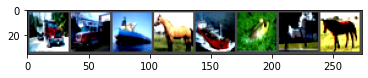

truck truck ship horse ship frog horse horse
frog frog plane horse ship ship horse horse


In [9]:
display_limit = 8

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
 
# show images

# images = trans_batch(images).to("cpu")

imshow(torchvision.utils.make_grid(images[:display_limit]))
# print labels
print(' '.join(classes[labels[j]] for j in range(display_limit)))

outputs = net.forward(images[:display_limit].to(device))
print(" ".join([classes[labels[i.argmax()]] for i in outputs]))

In [15]:
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cpu")

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train(epochs, trainloader, testloader, model_ft)

loss:  1.2112
loss:  0.6957
loss:  0.5634
loss:  0.4103
loss:  0.3121
epoch 4 acc: 0.6273333333333333
loss:  0.2513
loss:  0.2135
loss:  0.1124
loss:  0.0422
loss:  0.0291
epoch 9 acc: 0.6873333333333334
loss:  0.0211
loss:  0.0137
loss:  0.0122
loss:  0.0115
loss:  0.011
epoch 14 acc: 0.6853333333333333
loss:  0.0084
loss:  0.0099
loss:  0.0058
loss:  0.0061
loss:  0.0068
epoch 19 acc: 0.684
loss:  0.0083
loss:  0.0106
loss:  0.0107
loss:  0.0074
loss:  0.0053
epoch 24 acc: 0.689
loss:  0.0086
loss:  0.0063
loss:  0.0088
loss:  0.0089
loss:  0.0074
epoch 29 acc: 0.6863333333333334


epoch 29 acc: 0.6863333333333334

In [ ]:
# def save_net(path, net):
#   # TODO
 
# PATH = './cifar_net.pth'
# save_net(PATH, net)

In [ ]:
# def load_params(path, net):
#   # TODO

# load_params(PATH, net)

In [ ]:
# def validate(loader, name):
#   #TODO
 
# validate(trainloader, "train")
# validate(testloader, "test")

In [ ]:
# %load_ext tensorboard
# %reload_ext tensorboard

In [ ]:
# %tensorboard --logdir runs
# !kill 976

In [ ]:
# !rm -rf runs

In [ ]:
# !nvidia-smi